In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
The data were drawn from https://ourworldindata.org/ which were in turn drawn from various official Greek sources.
Their coronavirus dataset is freely available in https://github.com/owid/covid-19-data/tree/master/public/data.

In [2]:
# path = "/home/fivos/Documents/gigs/covida_data/owid/owid-covid-data.csv"
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2020-12-19 16:35:50--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13521906 (13M) [text/plain]
Saving to: ‘owid-covid-data.csv.2’

owid-covid-data.csv 100%[===================>]  12,89M  9,82MB/s    in 1,3s    

2020-12-19 16:35:57 (9,82 MB/s) - ‘owid-covid-data.csv.2’ saved [13521906/13521906]



# Take a look at the dataset

In [3]:
path = "owid-covid-data.csv"
df = pd.read_csv(path)
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'total_vaccinations_per_hundred', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'ag

In [4]:
gr = df.loc[ df["location"] == "Greece" ]

In [5]:
with pd.option_context('display.max_rows', 350, 'display.max_columns', 60):
    display(gr)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,total_vaccinations_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
19254,GRC,Europe,Greece,2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19255,GRC,Europe,Greece,2020-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19256,GRC,Europe,Greece,2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19257,GRC,Europe,Greece,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19258,GRC,Europe,Greece,2020-02-26,1.0,NaN,NaN,NaN,NaN,NaN,0.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19259,GRC,Europe,Greece,2020-02-27,3.0,2.0,NaN,NaN,NaN,NaN,0.288,0.192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19260,GRC,Europe,Greece,2020-02-28,4.0,1.0,NaN,NaN,NaN,NaN,0.384,0.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19261,GRC,Europe,Greece,2020-02-29,4.0,0.0,NaN,NaN,NaN,NaN,0.384,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19262,GRC,Europe,Greece,2020-03-01,7.0,3.0,NaN,NaN,NaN,NaN,0.672,0.288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87
19263,GRC,Europe,Greece,2020-03-02,7.0,0.0,NaN,NaN,NaN,NaN,0.672,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,10423056.0,83.479,45.3,20.396,14.524,24574.382,1.5,175.695,4.55,35.3,52.0,NaN,4.21,82.24,0.87


In [6]:
with pd.option_context('display.max_rows', 350, 'display.max_columns', 60):
    display(gr[["location", "date", "new_tests", "total_tests" ]]) #need display to show the dataframe when using with in jupyter

,location,date,new_tests,total_tests
19254,Greece,2020-02-02,NaN,NaN
19255,Greece,2020-02-09,NaN,NaN
19256,Greece,2020-02-15,NaN,NaN
19257,Greece,2020-02-23,NaN,NaN
19258,Greece,2020-02-26,NaN,NaN
19259,Greece,2020-02-27,NaN,NaN
19260,Greece,2020-02-28,NaN,NaN
19261,Greece,2020-02-29,NaN,NaN
19262,Greece,2020-03-01,NaN,NaN
19263,Greece,2020-03-02,NaN,NaN


In [7]:
inf_gr = gr[["date", "new_tests", "total_tests"]].copy()

# Inference
There appear to be missing data. There is no coherent book-keeping on daily tests so we infer number of tests per day from the number of cumulative tests. For this puprose we hold the assumption that in days, when cumulative numbers report is missing, the number of tests is the difference between two non-missing dates uniformly distributed to each date.

In [8]:
num_tests = [] 
k = 0
last = 0
s = 0
for total in inf_gr["total_tests"]:
    if np.isnan(total):
        k += 1
    else:
        k += 1
        new = []
        new = [ (total - last) /(k) ] * (k)
        s += ((total - last) /(k)) * k
        num_tests.extend(new)
        last = total
        k = 0
if k != 0:
    num_tests.extend([np.nan]*k)

In [9]:
len(inf_gr["new_tests"])

301

In [10]:
inf_gr["new_tests"] = num_tests

In [11]:
import numpy as np
from scipy.signal import find_peaks

tests = np.array(num_tests)
argpeaks, _ = find_peaks(tests, height=30000)
peaks = tests[argpeaks]
print("Extreme peaks were found for the dates:")
print(inf_gr["date"].array[argpeaks])

Extreme peaks were found for the dates:
<PandasArray>
['2020-07-29', '2020-08-04', '2020-08-19']
Length: 3, dtype: object


Text(0.5, 1.0, 'Infered number of tests each day')

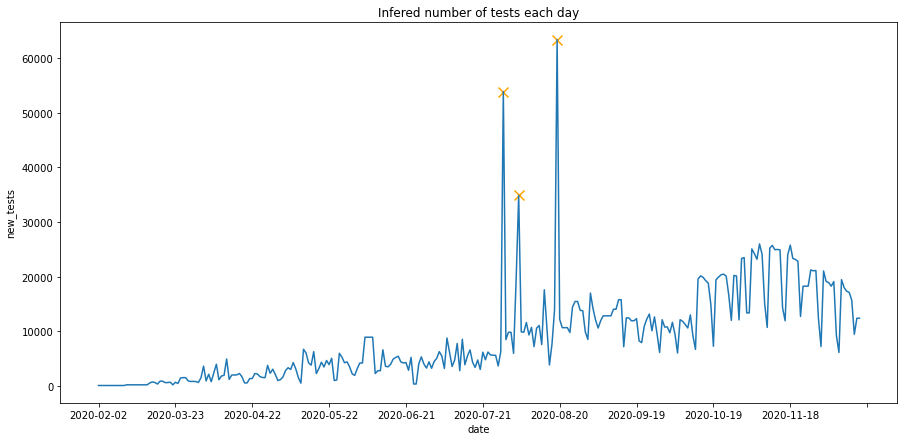

In [12]:
plt.figure(figsize=(15,7))
g = sns.lineplot(data=inf_gr, x="date", y="new_tests")
g.set(xticks=[ i for i in range(len(inf_gr)) if i%30==0] )
g.scatter(argpeaks, peaks, marker='x', color='orange', s=100 )
plt.title("Infered number of tests each day")